# Melbourne city council Pedestrian Footfall dataset Analysis

Dataset: https://data.melbourne.vic.gov.au/Transport/Pedestrian-Counting-System-2009-to-Present-counts-/b2ak-trbp

Note: you will need the Jupyer Lab plotly extension installed: https://plotly.com/python/getting-started

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

In [23]:
from pathlib import Path

data_path = Path("../data/Pedestrian_Counting_System___2009_to_Present__counts_per_hour_.csv")


df = pd.read_csv(data_path)


In [3]:
def load_and_clean_pedestrian_data(path):
    df = pd.read_csv(path)
    df["datetime"] = pd.to_datetime(
        {
            "day": df["Mdate"],
            "year": df["Year"],
            "hour": df["Time"],
            "month": pd.to_datetime(df["Month"], format='%B').dt.month
        }
    )
    return df

In [4]:
data_df = load_and_clean_pedestrian_data(DATA_PATH)
data_df.head()

ID               Date_Time  Year     Month  Mdate     Day  Time  \
0  2887628  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
1  2887629  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
2  2887630  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
3  2887631  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   
4  2887632  11/01/2019 05:00:00 PM  2019  November      1  Friday    17   

   Sensor_ID                   Sensor_Name  Hourly_Counts            datetime  
0         34          Flinders St-Spark La            300 2019-11-01 17:00:00  
1         39                  Alfred Place            604 2019-11-01 17:00:00  
2         37               Lygon St (East)            216 2019-11-01 17:00:00  
3         40  Lonsdale St-Spring St (West)            627 2019-11-01 17:00:00  
4         36               Queen St (West)            774 2019-11-01 17:00:00

In [5]:
YEARS = sorted(data_df["Year"].unique())
SENSORS = data_df["Sensor_Name"].unique()
print(len(SENSORS))

69


In [6]:
data_df["datetime"]

0         2019-11-01 17:00:00
1         2019-11-01 17:00:00
2         2019-11-01 17:00:00
3         2019-11-01 17:00:00
4         2019-11-01 17:00:00
                  ...        
3132341   2020-04-30 23:00:00
3132342   2020-04-30 23:00:00
3132343   2020-04-30 23:00:00
3132344   2020-04-30 23:00:00
3132345   2020-04-30 23:00:00
Name: datetime, Length: 3132346, dtype: datetime64[ns]

## Yearly plots

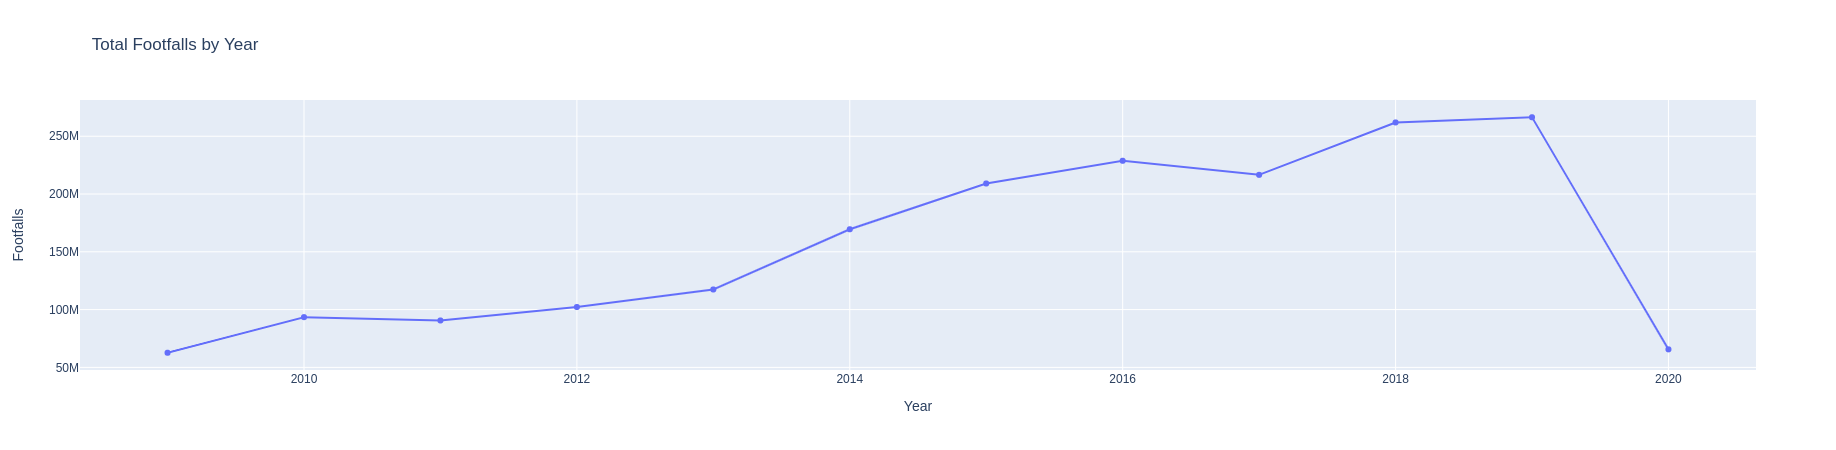

In [7]:
year_counts = data_df.groupby("Year")["Hourly_Counts"].sum()
px.line(x=year_counts.index, y=year_counts, title="Total Footfalls by Year", labels={"x":"Year", "y":"Footfalls"}).update_traces(mode='lines+markers')

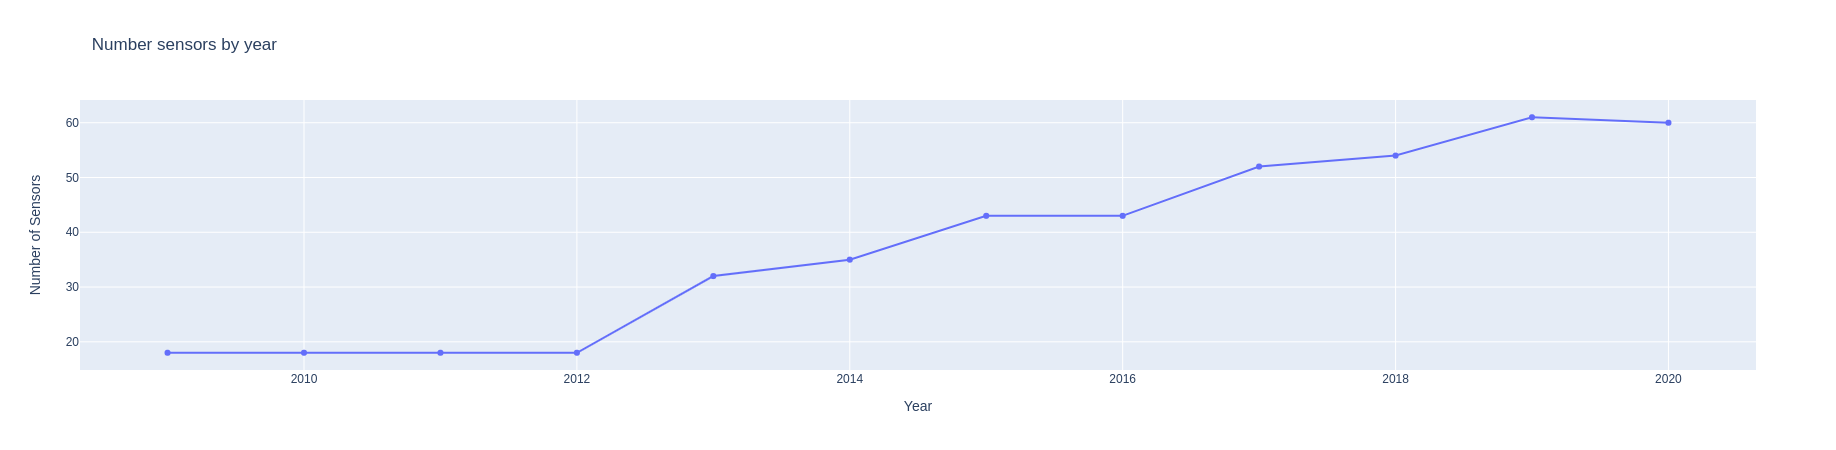

In [8]:
num_sensors = data_df.groupby("Year")["Sensor_Name"].nunique()
px.line(x=num_sensors.index, y=num_sensors, title="Number sensors by year", labels={"x":"Year", "y":"Number of Sensors"}).update_traces(mode='lines+markers')

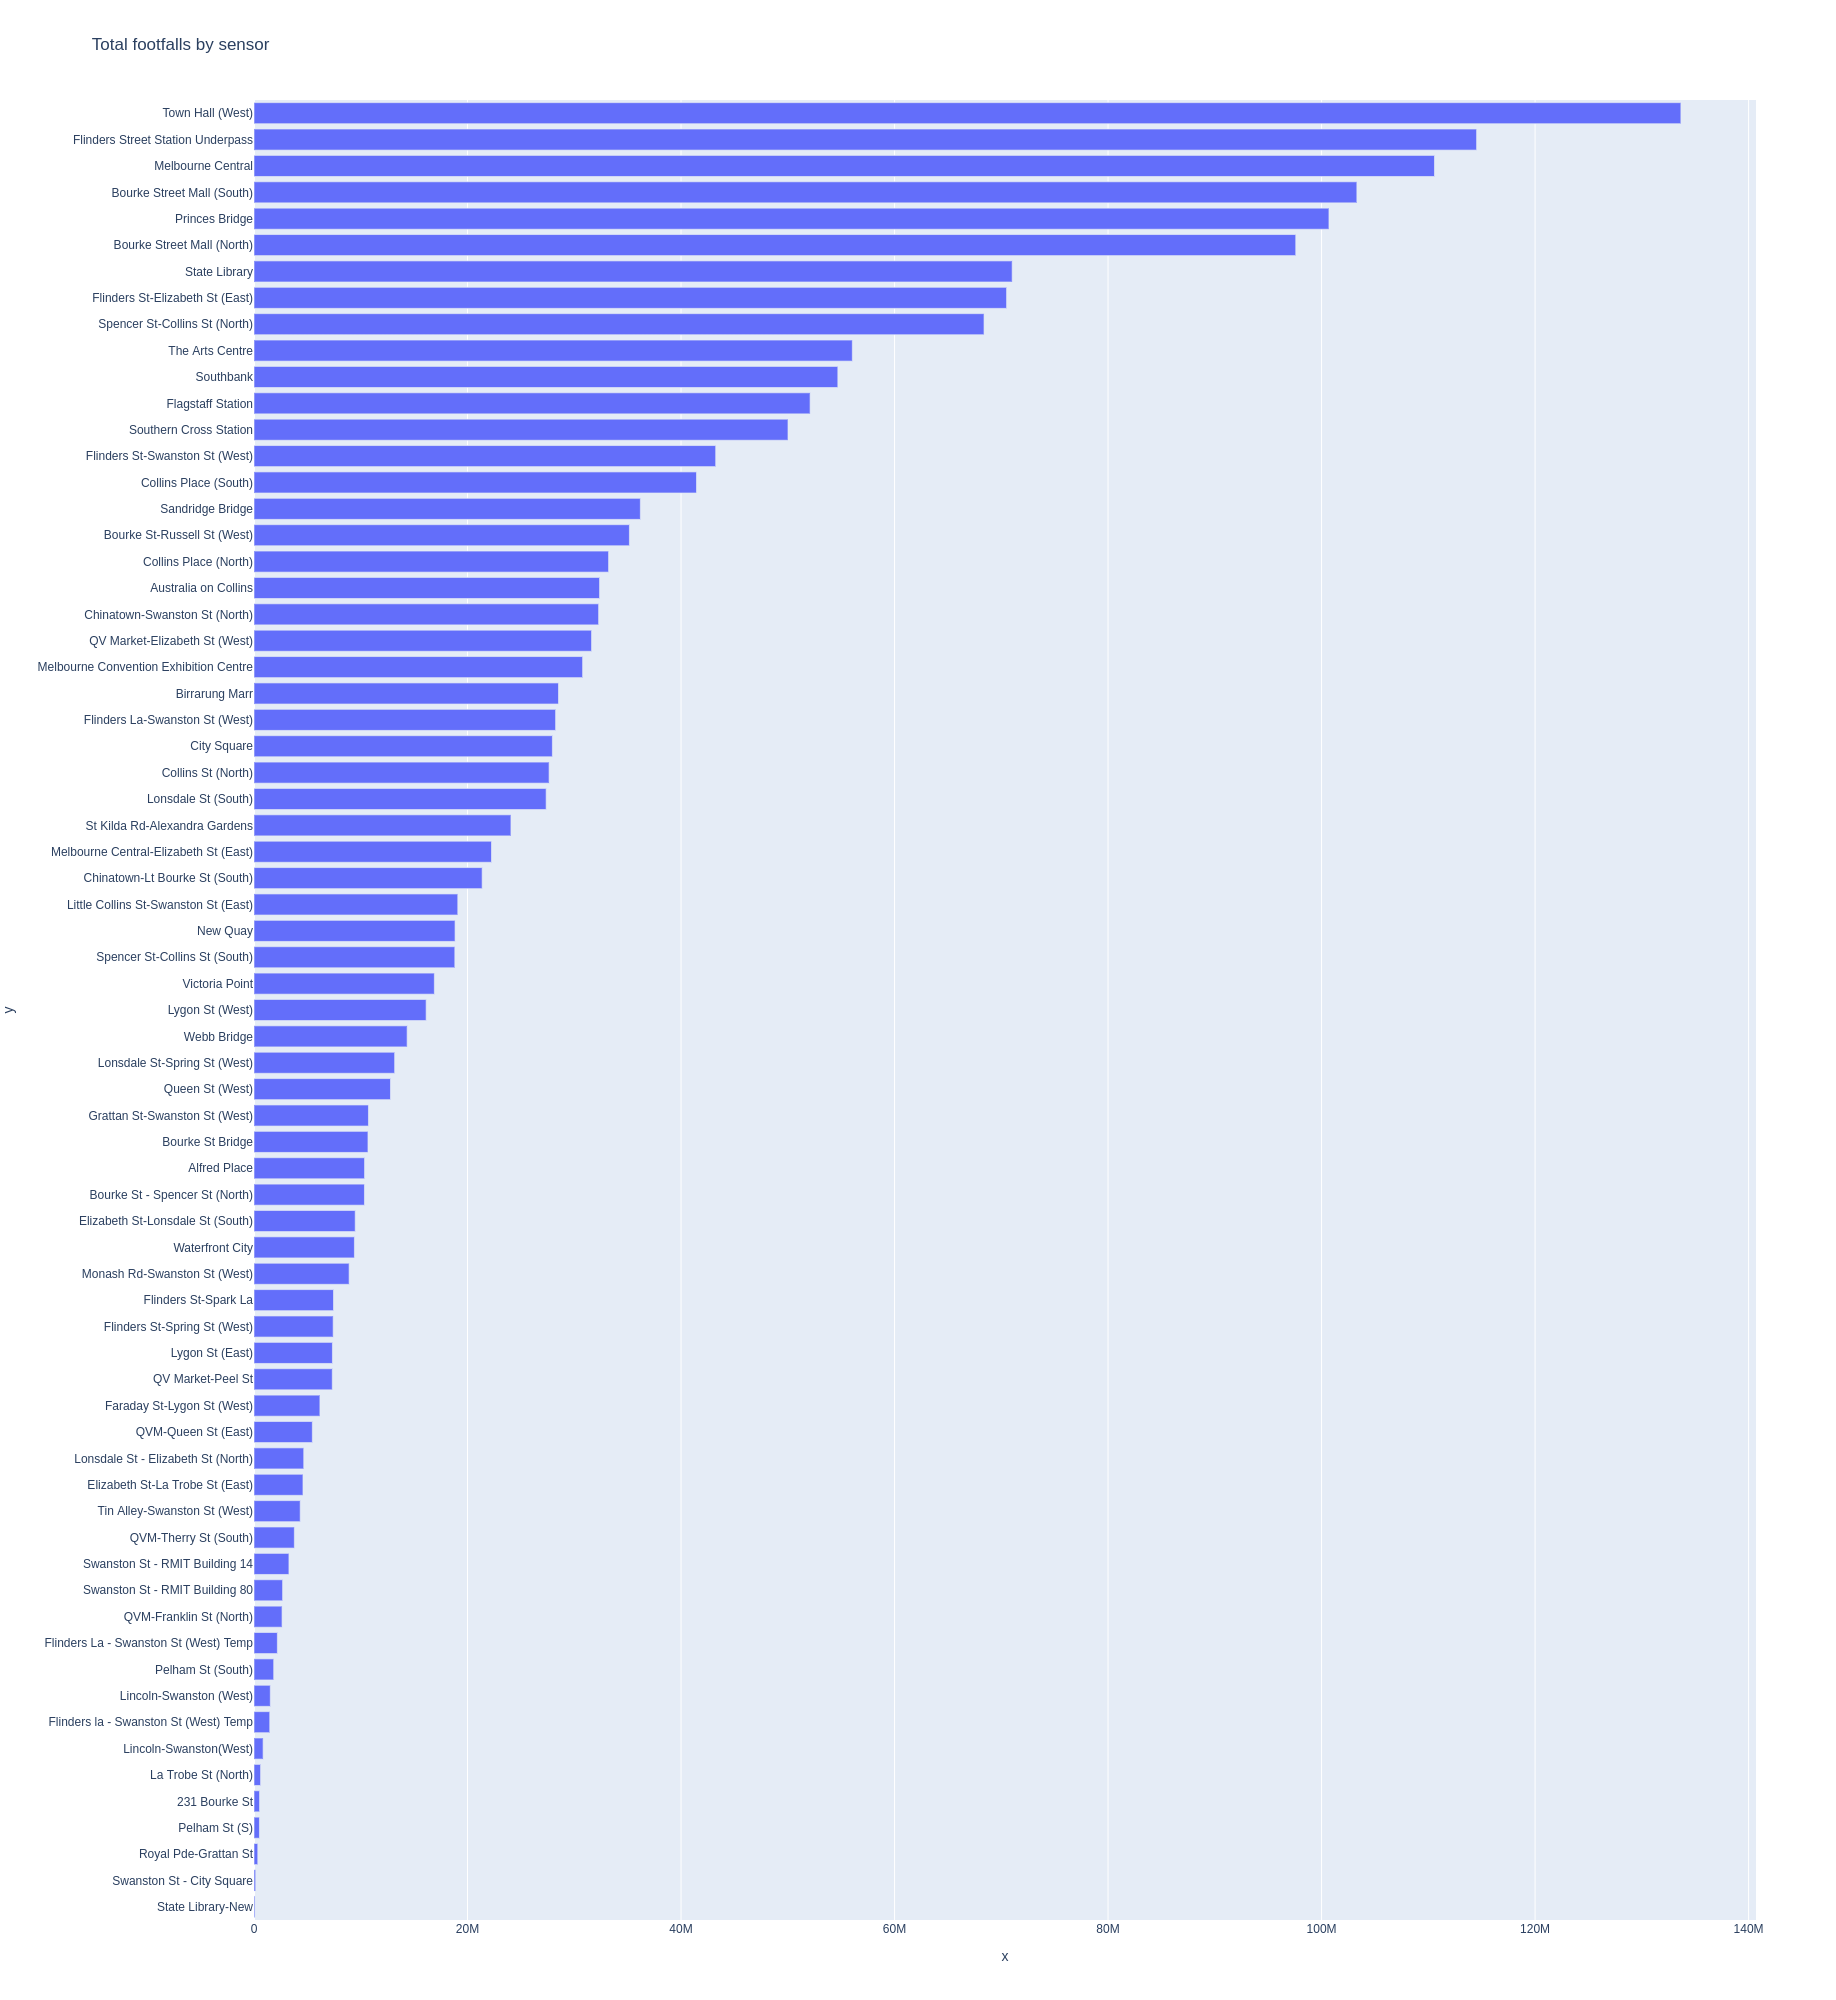

In [9]:
def plot_by_sensor(df, year=None):
    """Make a bar chart for total footfals for each sensor"""
    title = "Total footfalls by sensor"
    if year is not None:
        df = df[df["Year"] == year]
        title = title + f" for {year}"
    total = df.groupby("Sensor_Name")["Hourly_Counts"].sum().sort_values()
    return px.bar(y=total.index, x=total, title=title, orientation='h', height=2000, width=1000)

plot_by_sensor(data_df)

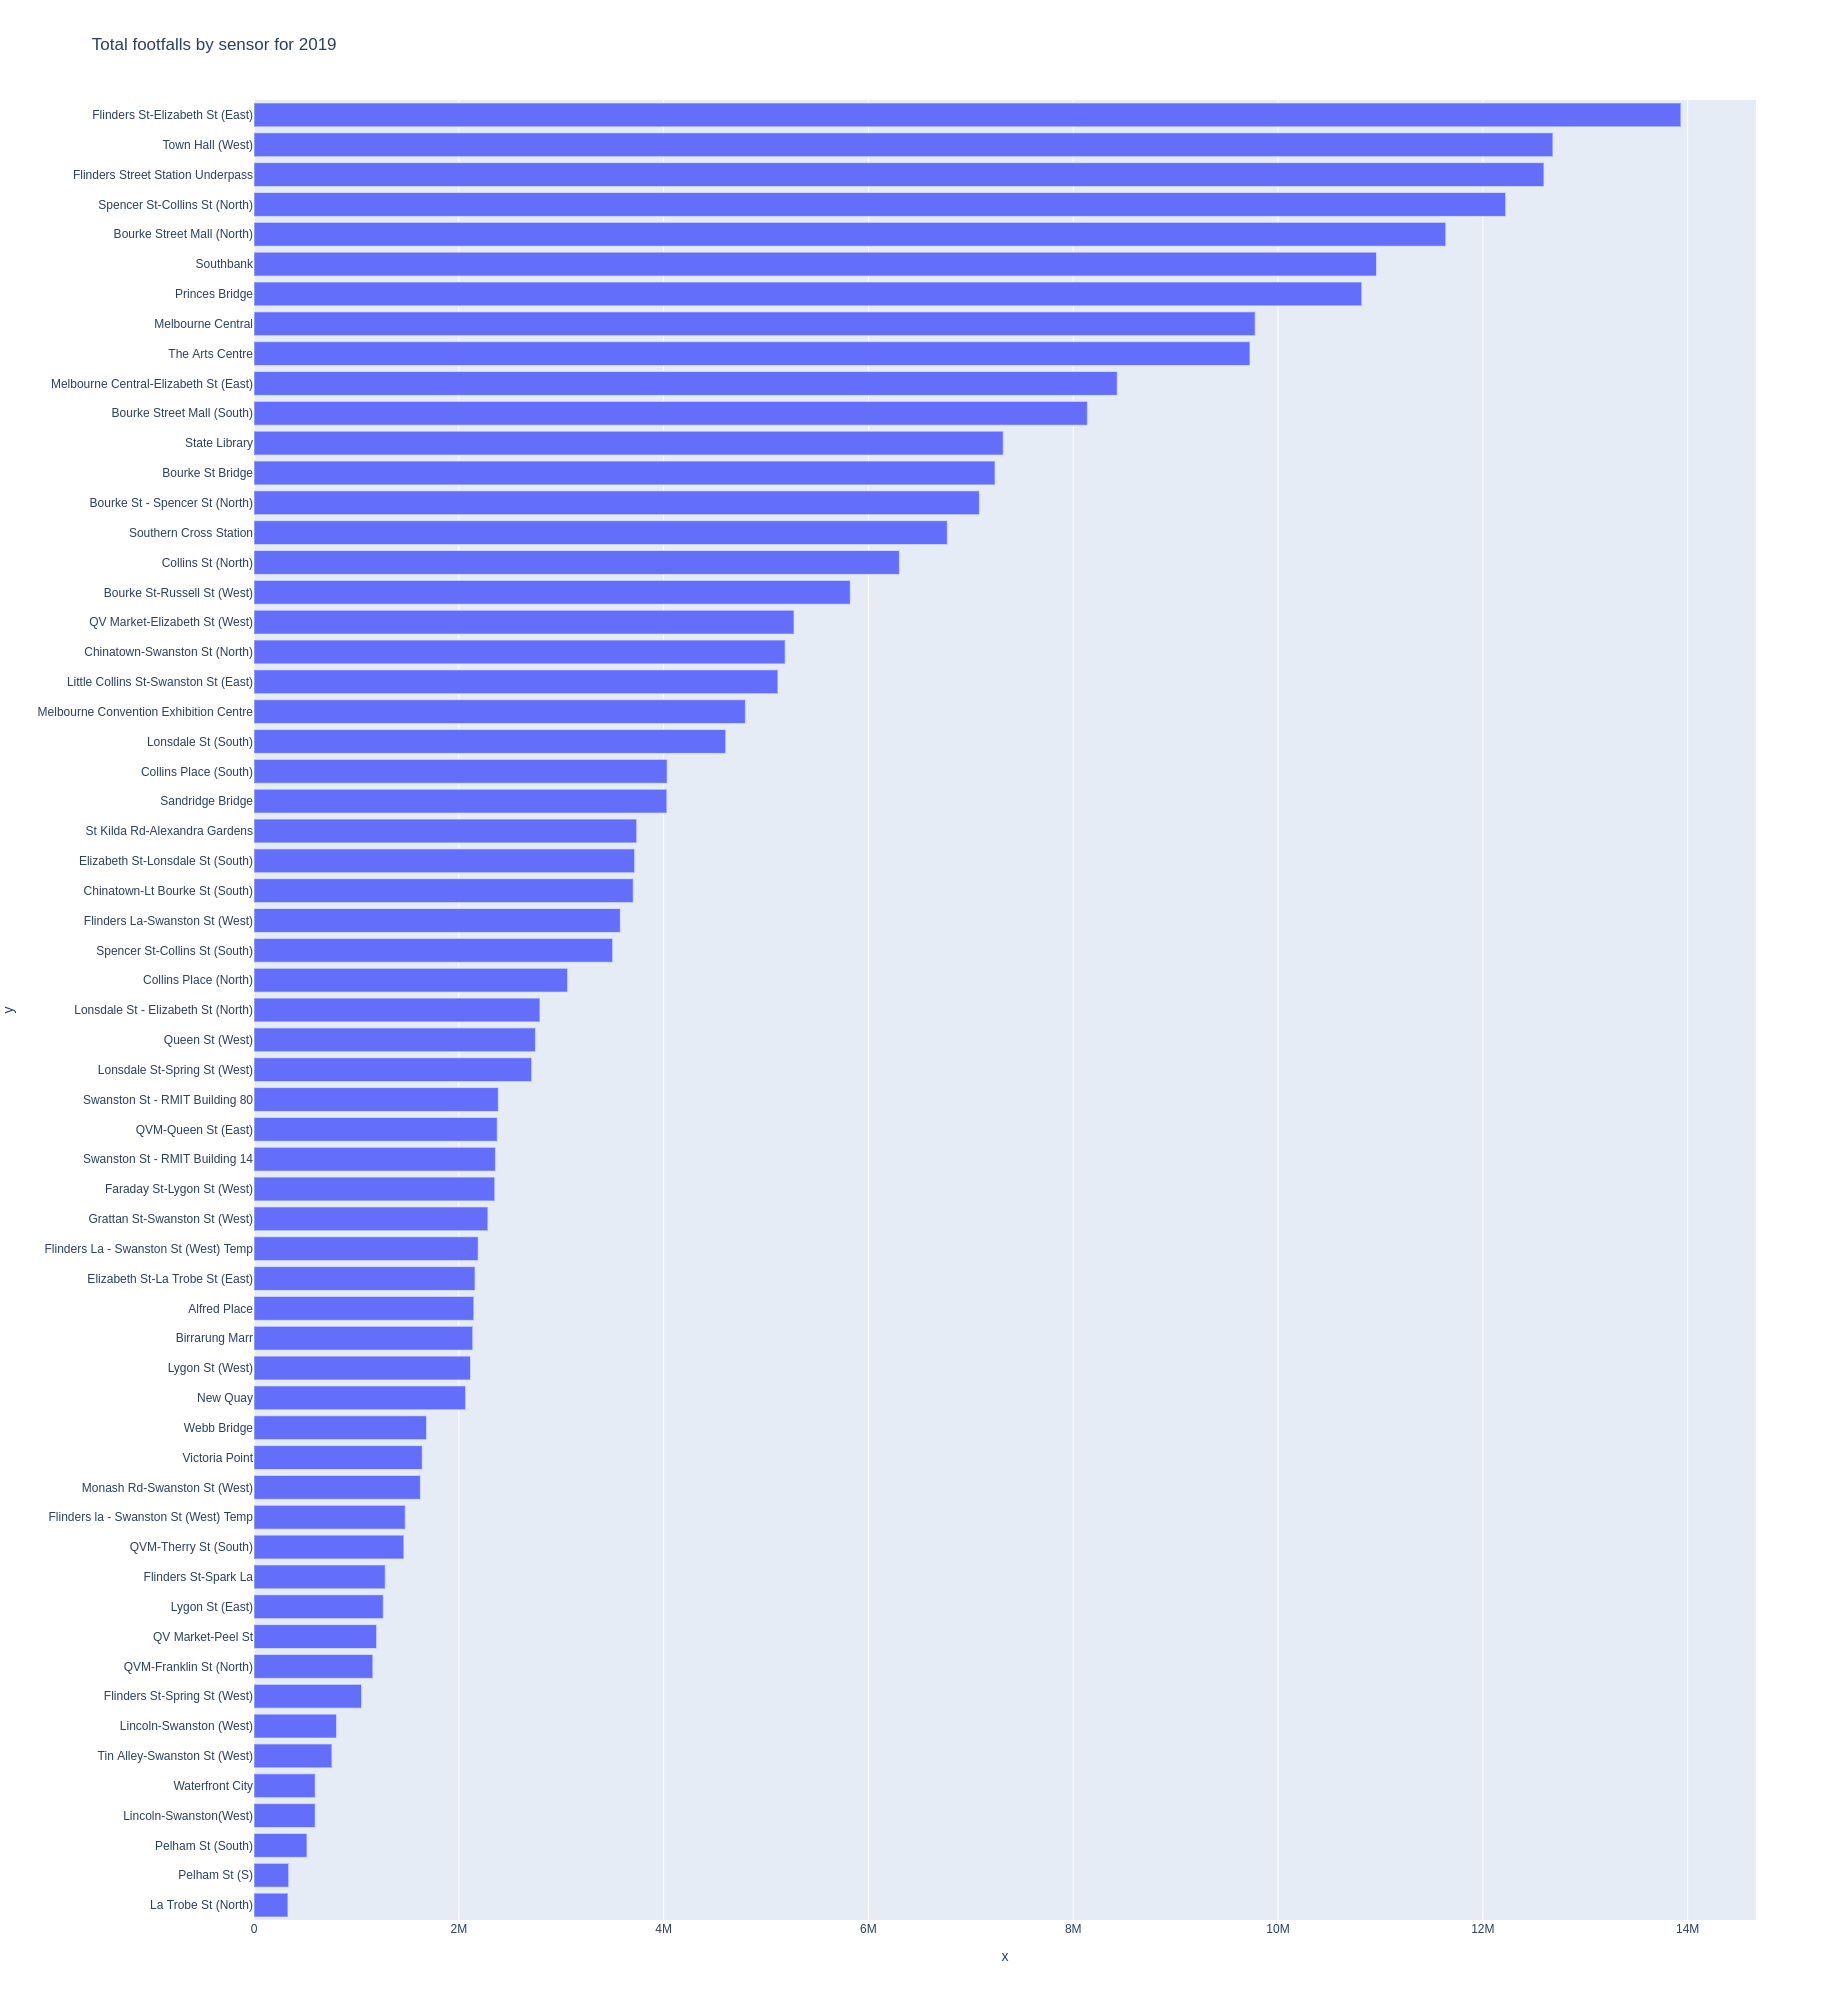

In [10]:
plot_by_sensor(data_df, year=2019)

In [11]:
data_df["Year"].isin(range(2017, 2020))

0           True
1           True
2           True
3           True
4           True
           ...  
3132341    False
3132342    False
3132343    False
3132344    False
3132345    False
Name: Year, Length: 3132346, dtype: bool

In [12]:
data_df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()

Sensor_Name    Year
231 Bourke St  2020     524014
Alfred Place   2014     594683
               2015    1705448
               2016    1840689
               2017    1731057
                        ...   
Webb Bridge    2016    1379041
               2017    1371017
               2018    1722797
               2019    1685096
               2020     446223
Name: Hourly_Counts, Length: 452, dtype: int64

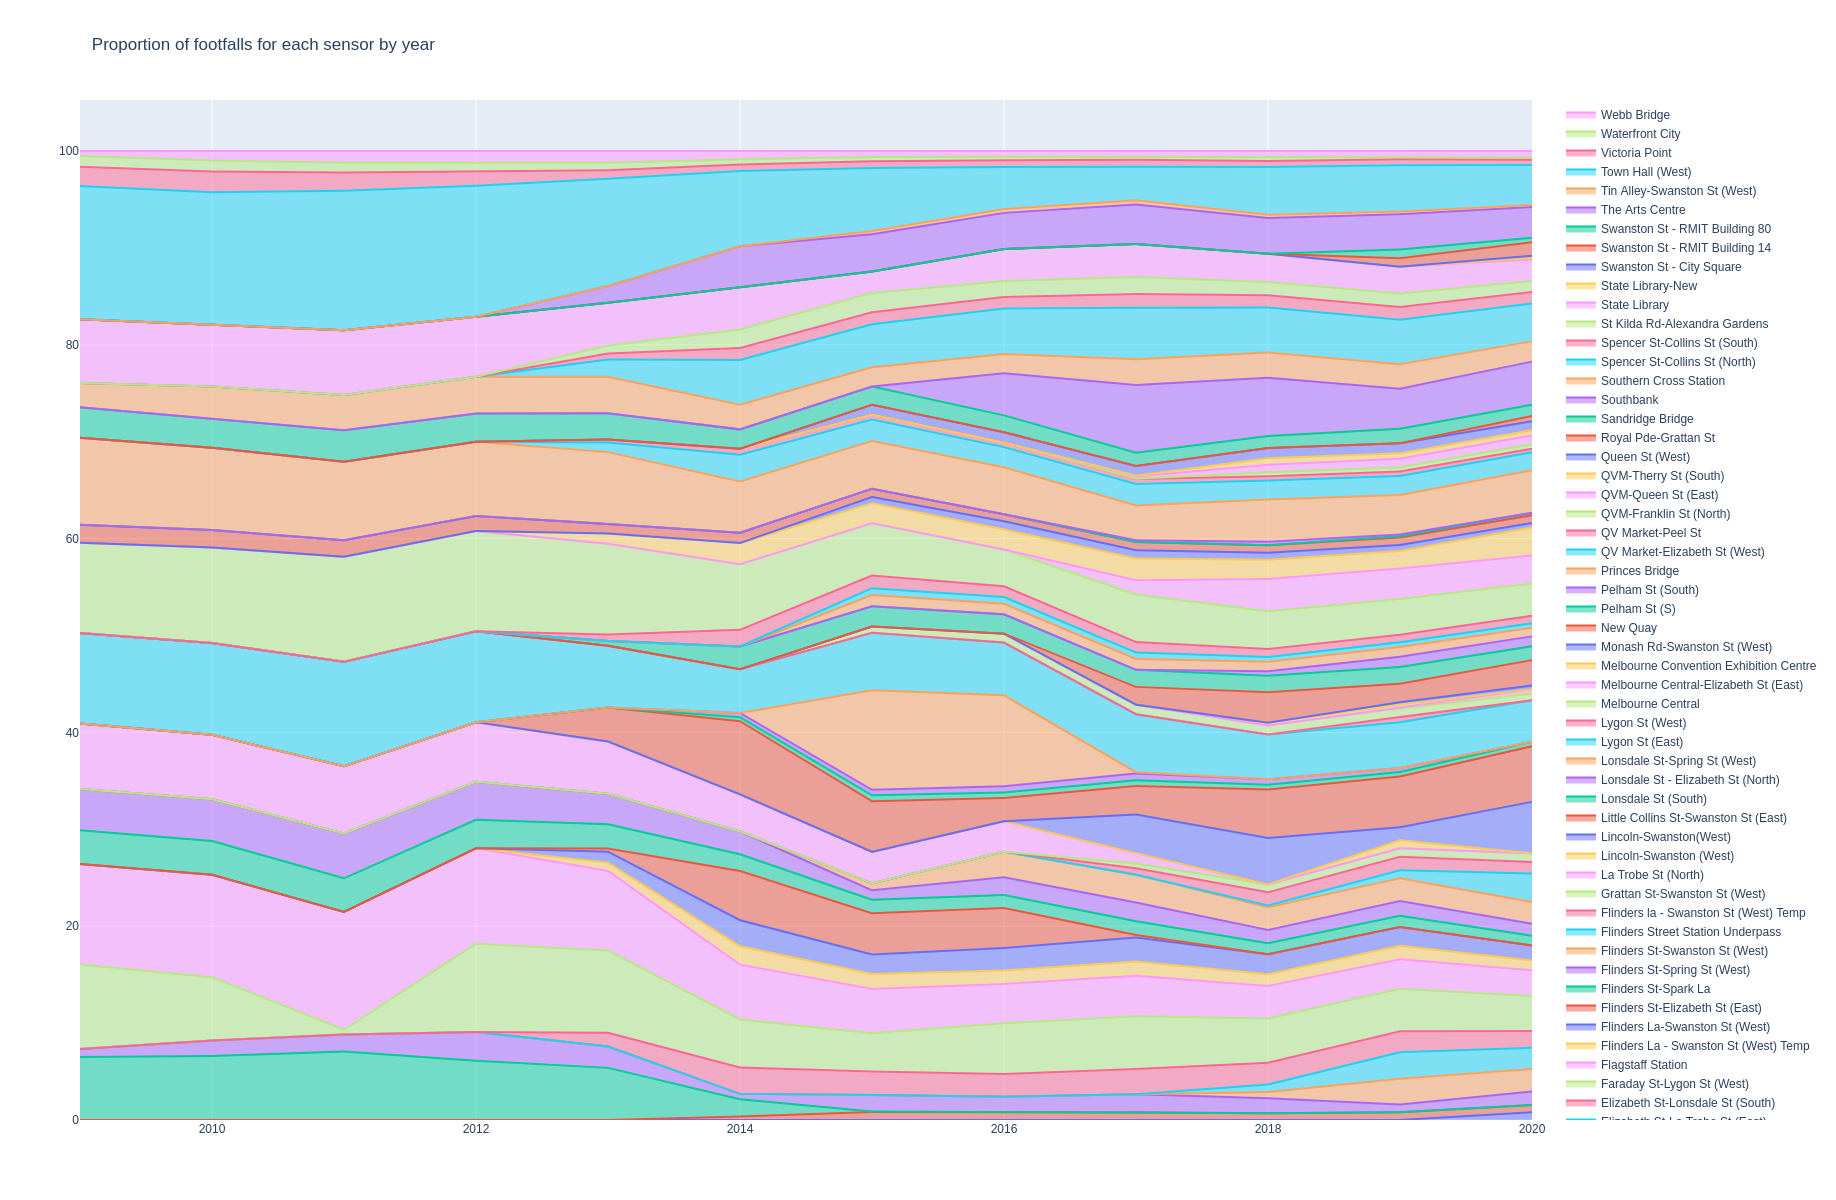

In [13]:
# maybe when a subset of sensors are viewed, it should be a line chart
# otherwise, using the stacked chart gives the false impression that the currently selected
# sensors are all the traffic

# other problem with stacked area chart is that it makes the sensors that come online
# at a specific year look like they have readings during the year before, but the values are discrete obviously

# another problem is not being able to hover over all traces

def make_stacked_sensor_plot(df, years=None, sensors=None, normalised=True):
    if years is not None:
        df = df[df["Year"].isin(years)]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(sensors)]
    sensor_years_s = df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()
    sensor_dfs = [(sensor, dfx.reset_index("Sensor_Name")) for sensor, dfx in sensor_years_s.groupby(level=0)]

    fig = go.Figure()
    for sensor, df in sensor_dfs:   
        fig.add_trace(go.Scatter(
            x=df.index, y=df["Hourly_Counts"],
            #mode='lines',
            name=sensor,
            stackgroup='one',
            groupnorm='percent' if normalised else "",
        ))

    fig.update_layout(width=1500, height=1200, title="Proportion of footfalls for each sensor by year")
    return fig

make_stacked_sensor_plot(data_df)

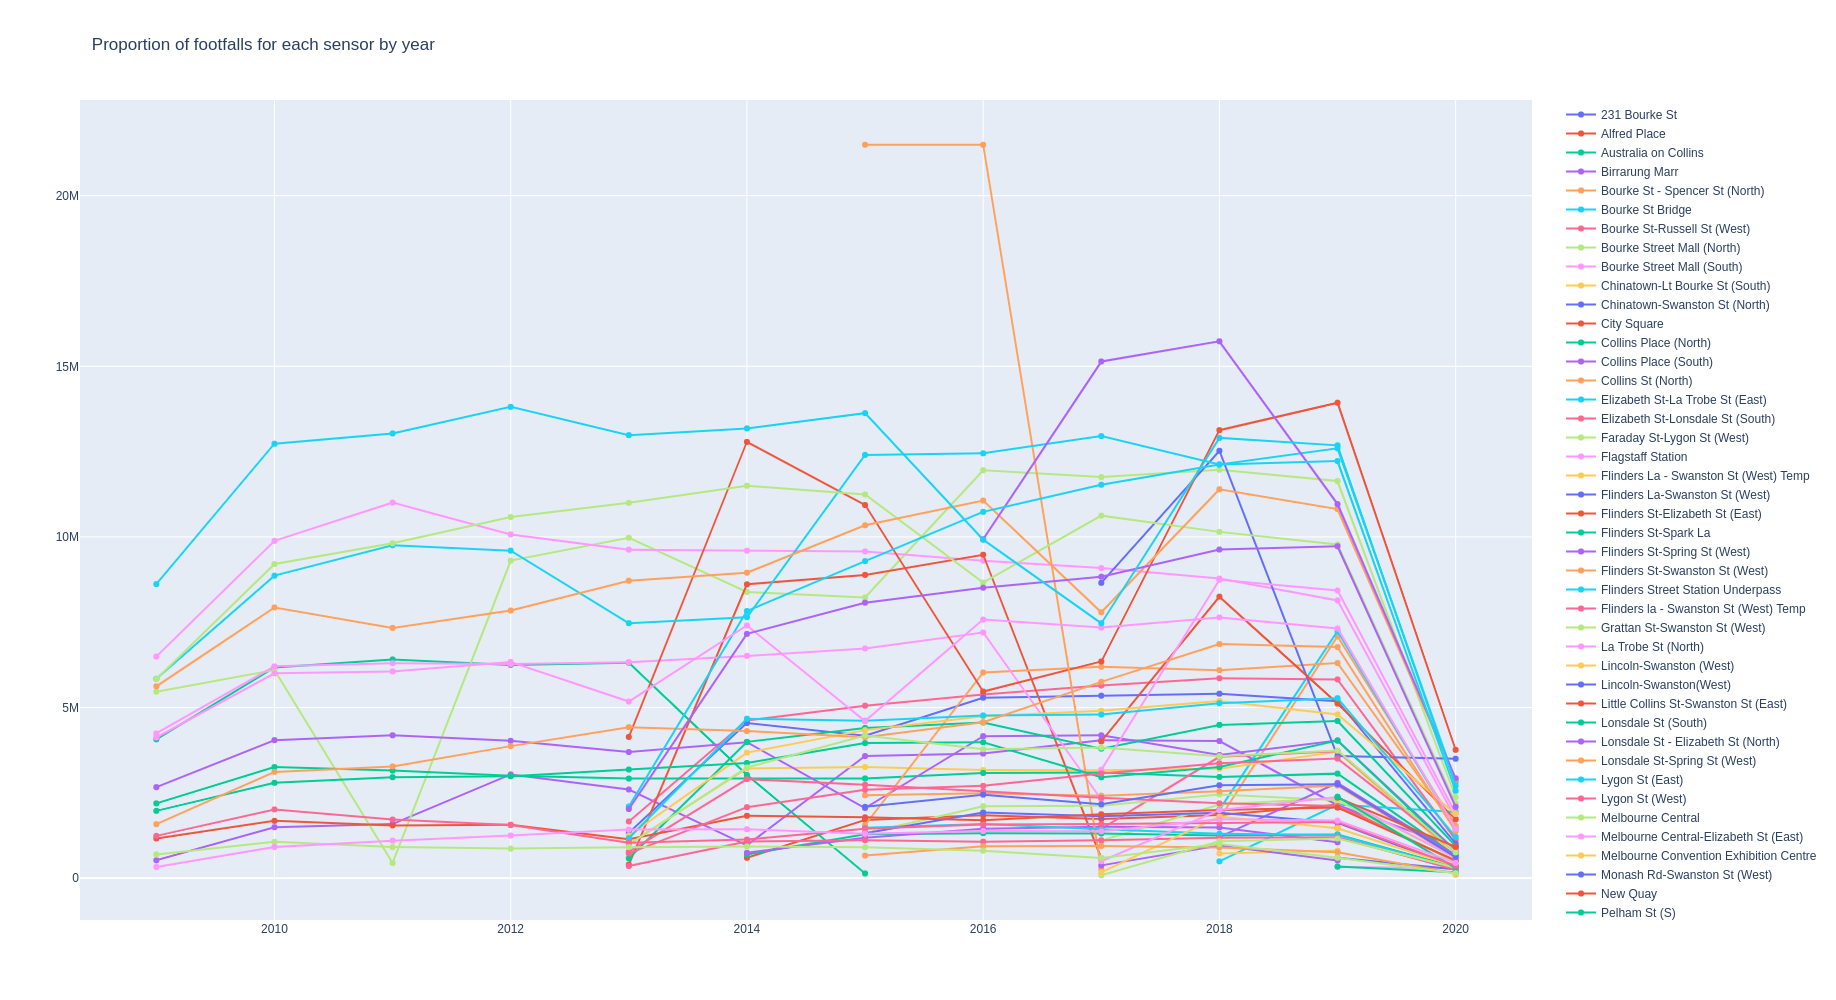

In [14]:
# maybe when a subset of sensors are viewed, it should be a line chart
# otherwise, using the stacked chart gives the false impression that the currently selected
# sensors are all the traffic

# other problem with stacked area chart is that it makes the sensors that come online
# at a specific year look like they have readings during the year before, but the values are discrete obviously

# another problem is not being able to hover over all traces

def make_line_plot(df, years=None, sensors=None, normalised=True):
    if years is not None:
        df = df[df["Year"].isin(years)]
    if sensors is not None:
        df = df[df["Sensor_Name"].isin(sensors)]
    sensor_years_s = df.groupby(["Sensor_Name", "Year"])["Hourly_Counts"].sum()
    sensor_dfs = [(sensor, dfx.reset_index("Sensor_Name")) for sensor, dfx in sensor_years_s.groupby(level=0)]

    fig = go.Figure()
    for sensor, df in sensor_dfs:   
        fig.add_trace(go.Scatter(
            mode="lines+markers",
            x=df.index, y=df["Hourly_Counts"],
            name=sensor,
            hovertemplate = "%{y:,}",
            # don't truncate the hover text
            hoverlabel={"namelength":-1},
            #line=go.scatter.Line(color="gray"),
        ))

    fig.update_layout(clickmode="event+select", width=1500, height=1000, title="Proportion of footfalls for each sensor by year")
    #fig.update_yaxes(hoverformat=".2")
    return fig

make_line_plot(data_df)

In [15]:
year_df = data_df[data_df["Year"] == 2009]
sensors = year_df.groupby("Sensor_Name")["Hourly_Counts"].sum()
series = sensors.sort_values(ascending=False).cumsum()/sensors.sum()

In [16]:
series.head(10)

Sensor_Name
Town Hall (West)                     0.137524
Bourke Street Mall (South)           0.241162
Flinders Street Station Underpass    0.334415
Melbourne Central                    0.427560
Princes Bridge                       0.517277
Bourke Street Mall (North)           0.604497
Flagstaff Station                    0.672169
State Library                        0.737950
Australia on Collins                 0.802876
Collins Place (South)                0.845422
Name: Hourly_Counts, dtype: float64